# Social graphs and interactions : Assignment 2

## Data

Our files are available at : LINK.

The code below is used to download the data from Wikipedia, and then create the graph.
Please run it to create the graph (the data won't be downloaded) and skip to the next part for the actual assignment.

Please run the command below if you don't alread have the `powerlaw` package installed.

In [3]:
#pip install powerlaw

In [55]:
# Imports
import re, requests, json, urllib
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import itertools
import powerlaw
from fa2 import ForceAtlas2
import random

In [5]:
# Creating the query model
base_url = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
content = 'prop=revisions&rvprop=content'
rvslot = 'rvslots=main'
dataformat = 'format=json'

def create_api_call(title):
    title = f'titles={title}'
    query = '%s%s&%s&%s&%s&%s' %  (base_url,action,title,content,rvslot,dataformat)
    return query

l = []

def get_data_from_api(api_url):    
    try:
        r  = requests.get(api_url)
        r.raise_for_status()
        if r.status_code != 204:
            return r.json()
    except:
        #print(api_url)
        l.append(api_url)
    
def create_file(path, title, text):
    missing_counter = 0
    try:
        with open(f'{path}/{title}.txt', 'w') as f:
            f.write(text)
    except:
        missing_counter += 1

dc_df = pd.read_csv('dc.csv')['WikiLink']
marvel_df = pd.read_csv('marvel.csv')['WikiLink']

quick_list_dc = dc_df.dropna().to_list()
quick_list_marvel = marvel_df.dropna().to_list()

dc_dict = {hero:{'Universe':'DC'} for hero in quick_list_dc}
combined_dict = {hero:{'Universe': 'Marvel'} for hero in quick_list_marvel}

combined_dict.update(dc_dict)
combined_list = combined_dict.keys()

# Downloading all the files
#[create_file('Heroes', hero, json.dumps(get_data_from_api(create_api_call(hero)))) for hero in combined_list]

# Creating the Superheroes graph from the data we downloaded
G = nx.DiGraph()

for hero, params in combined_dict.items():
    # Adding all the nodes in the directed graph, along with their universe, saved as an attribute
    G.add_node(hero, universe=params['Universe'])
    try:
        # Getting all the links between the saved pages and creating the edges of the graph
        with open(f'Heroes/{hero}.txt') as f:
            lines = f.read().replace('\n', "")
        links = re.findall(r'(?<=\[\[).+?(?=\])', lines)
        links = [f.split('|')[0] for f in links]
        for link in links:
            for name in combined_dict.keys():
                if link == name:
                    G.add_edge(hero, name)
    except:
        pass
        #print(hero, params['Universe'])
        
# Removing outliers
isolated_nodes = nx.isolates(G)
isolated_nodes = [n for n in isolated_nodes]
G.remove_nodes_from(isolated_nodes)
G_undirectional = G.to_undirected().copy()

## Basic stats

In [20]:
#Calculating different statistics
indegree_distribution      = sorted((d for n, d in G.in_degree()), reverse=True)
outdegree_distribution     = sorted((d for n, d in G.out_degree()), reverse=True)
undirectional_distribution = sorted((d for n, d in G_undirectional.degree()), reverse=True)
indegree_mean              = np.mean(indegree_distribution)
outdegree_mean             = np.mean(outdegree_distribution)
indegree_median            = np.median(indegree_distribution)
outdegree_median           = np.median(outdegree_distribution)
indegree_mode              = max(set(indegree_distribution), key=indegree_distribution.count)
outdegree_mode             = max(set(outdegree_distribution), key=outdegree_distribution.count)
indegree_min               = min(indegree_distribution)
outdegree_min              = min(outdegree_distribution)
indegree_max               = max(indegree_distribution)
outdegree_max              = max(outdegree_distribution)

In [21]:
print('Outdegree:', f'mean={outdegree_mean},', f'minimum={outdegree_min},', f'max={outdegree_max},', f'mode={outdegree_mode}')
print('Indegree:', f'mean={indegree_mean},', f'minimum={indegree_min},', f'max={indegree_max},', f'mode={indegree_mode}')

Outdegree: mean=11.037373737373738, minimum=0, max=92, mode=0
Indegree: mean=11.037373737373738, minimum=0, max=401, mode=1


>Write a short paragraph describing the network. The paragraph should contain the following information

>- The number of nodes and links.
>- The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

The total number of nodes is 2019 while the total number of edges is 23338. The average, mean, meadian, min and max is printed in the cell above. What can be noted is that the mean and the minimum are the same for both out- and in-degrees while the maximum and the mode is different. This means that the the maximum in-degree is significantly larger compared to out-degree. 

>We also want the degree distributions and a plot of the network

>- Create in- and out-going degree distributions as described in Lecture 5.

In [22]:
# Simple visualisation of the degree distributions
# Starting by creating a dict with the count of the frequencies of the degrees

indegree_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(indegree_distribution)])
outdegree_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(outdegree_distribution)])
undirectional_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(undirectional_distribution)])
#all_distributions = [indegree_dist, outdegree_dist, undirectional_dist]
all_distributions = [
    {
    'x': indegree_dist.keys(),
    'y': indegree_dist.values(),
    'title': 'Indegree Distribution',
    'xaxis': 'Indegrees'
    },
    {
    'x': outdegree_dist.keys(),
    'y': outdegree_dist.values(),
    'title': 'Outdegree Distribution',
    'xaxis': 'Outdegrees'
    },
    {    
    'x': undirectional_dist.keys(),
    'y': undirectional_dist.values(),
    'title': 'Distribution of undirectional graph',
    'xaxis': 'Degrees'
    }
]

#Plotting function for distributions
def plot_degrees(x, y, title, xaxis, yaxis='Frequency (Count)'):    
    plt.figure(figsize=(10,7))
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.show()

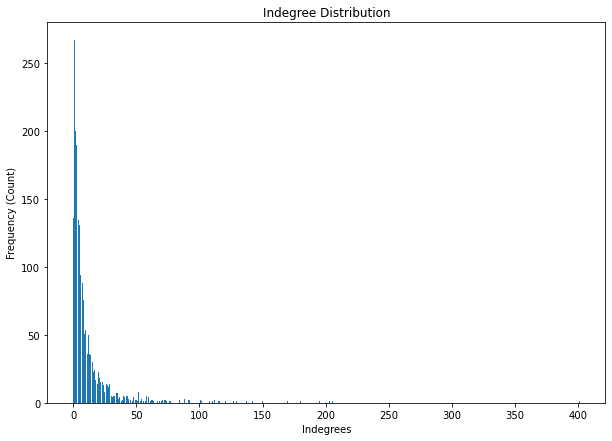

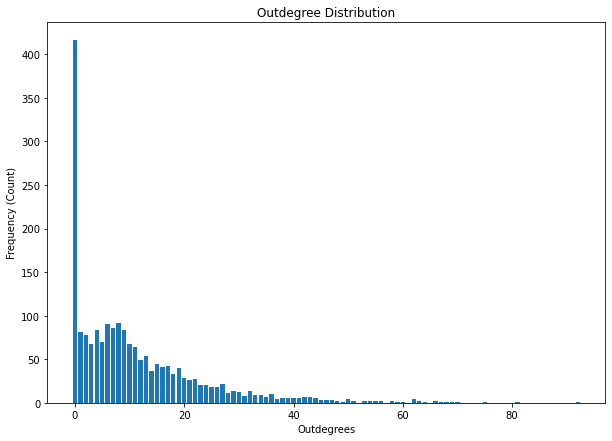

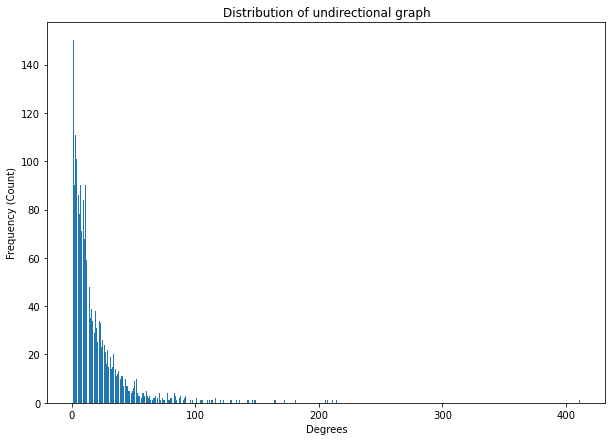

In [23]:
#Looping through for plotting the distributions
for i in all_distributions:
    plot_degrees(i['x'], i['y'], i['title'], i['xaxis'])

>- Estimate the slope of the incoming degree distribtion as described in Lecture 5.


Calculating best minimal value for power law fit
Alpha: 3.8062497913306785
xmin: 101.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


<AxesSubplot:>

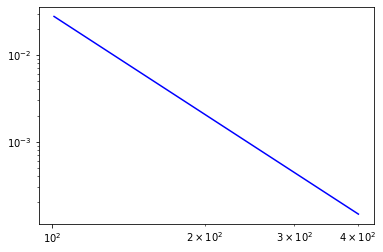

In [24]:
results = powerlaw.Fit(list(indegree_dist.keys()))
print("Alpha:", results.alpha)
print("xmin:", results.xmin)
results.power_law.plot_pdf(color='b')

>- Plot the network using the Force Atlas algorithm as described in Lecture 5.

>(Friendly hint: Remember figure captions.)

In [25]:
#We can create the lists for color and degree with the following to be passed to the forceatlas algorithm
#node_colors = ['red' if G_directional.nodes[node]['']]
colors = []
for node in G_undirectional.nodes():
    if G_undirectional.nodes[node]['universe'] == 'Marvel':
        colors.append('red')
    else:
        colors.append('blue')

degrees = []
for hero in G_undirectional.degree:
    degrees.append(hero[1])


edge_color_map = ['black' if G_undirectional.nodes[u]['universe'] != G_undirectional.nodes[v]['universe'] 
                  else 'red' if G_undirectional.nodes[u]['universe']=='Marvel' 
                  else 'blue' for (u,v) in list(G_undirectional.edges(data=False))]

In [26]:
forceatlas = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.5,
                        adjustSizes=False,
                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        # Tuning
                        scalingRatio=20,
                        strongGravityMode=False,
                        gravity=1000.0,
                        # Log
                        verbose=True)

positions = forceatlas.forceatlas2_networkx_layout(G_undirectional, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_undirectional, positions, node_size=degrees, node_color=colors, label=[''])
nx.draw_networkx_edges(G_undirectional, positions, edge_color=edge_color_map, alpha=0.5, width=0.1, arrowstyle="-")
plt.figure(figsize=(40,40))
plt.axis('off')
plt.show()


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

## Communities

>Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

>Write a paragraph about your work to identify the communities. The paragraph should include

>- Information about the algorithm you used to find communities.
>- The value of modularity for your network.
>- The number of communities and their sizes (in terms of number of nodes).

In [27]:
superhero_graph = G

# For this part, we want the graph to be undirected
G2 = superhero_graph.to_undirected()

# And to have only the superheroes from the Marvel universe
marvel_graph = nx.Graph()
marvel_graph.add_edges_from([(u, v) for (u, v) in G2.edges if G2.nodes[u]['universe'] == 'Marvel' and G2.nodes[v]['universe'] == 'Marvel'])

Below we used the Louvain algorithm to detect communities inside the network of Marvel superheroes (the largest of the two universes in terms of the number of Wikipedia pages downloaded). This algorithm tries to maximize the modularity of the whole network.

As a reminder, the formula for the modularity is:

$M = \sum_{c=1}^{n_c} [\frac{L_c}{L} - (\frac{k_c}{2L})^2]$

We sum over all the communities that were found, $L$ is the number of links of the whole network, $L_c$ is the number of links of the community $c$, and $k_c$ is the total degree of the community.

In [28]:
import community

# Using the Louvain algorithm implemented in the community package to compute the best partition
partition = community.best_partition(marvel_graph)
print(len(set(partition.values())), "communities found.")

modularity = community.modularity(partition, marvel_graph)
print("Modularity =", modularity)

13 communities found.
Modularity = 0.4232565516618172


Thus we found the communities in the Marvel graph, and the resulting modularity. Below is a cell listing the sizes of the communities.

In [29]:
# Counting the sizes of the communities
temp = list(partition.values())
for i in set(temp):
    print("The size of community", i, "is", temp.count(i))

The size of community 0 is 385
The size of community 1 is 200
The size of community 2 is 378
The size of community 3 is 346
The size of community 4 is 2
The size of community 5 is 18
The size of community 6 is 4
The size of community 7 is 12
The size of community 8 is 48
The size of community 9 is 18
The size of community 10 is 3
The size of community 11 is 142
The size of community 12 is 4


>Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

100%|██████████| 2000/2000 [00:21<00:00, 95.23it/s] 


BarnesHut Approximation  took  6.65  seconds
Repulsion forces  took  13.10  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.54  seconds


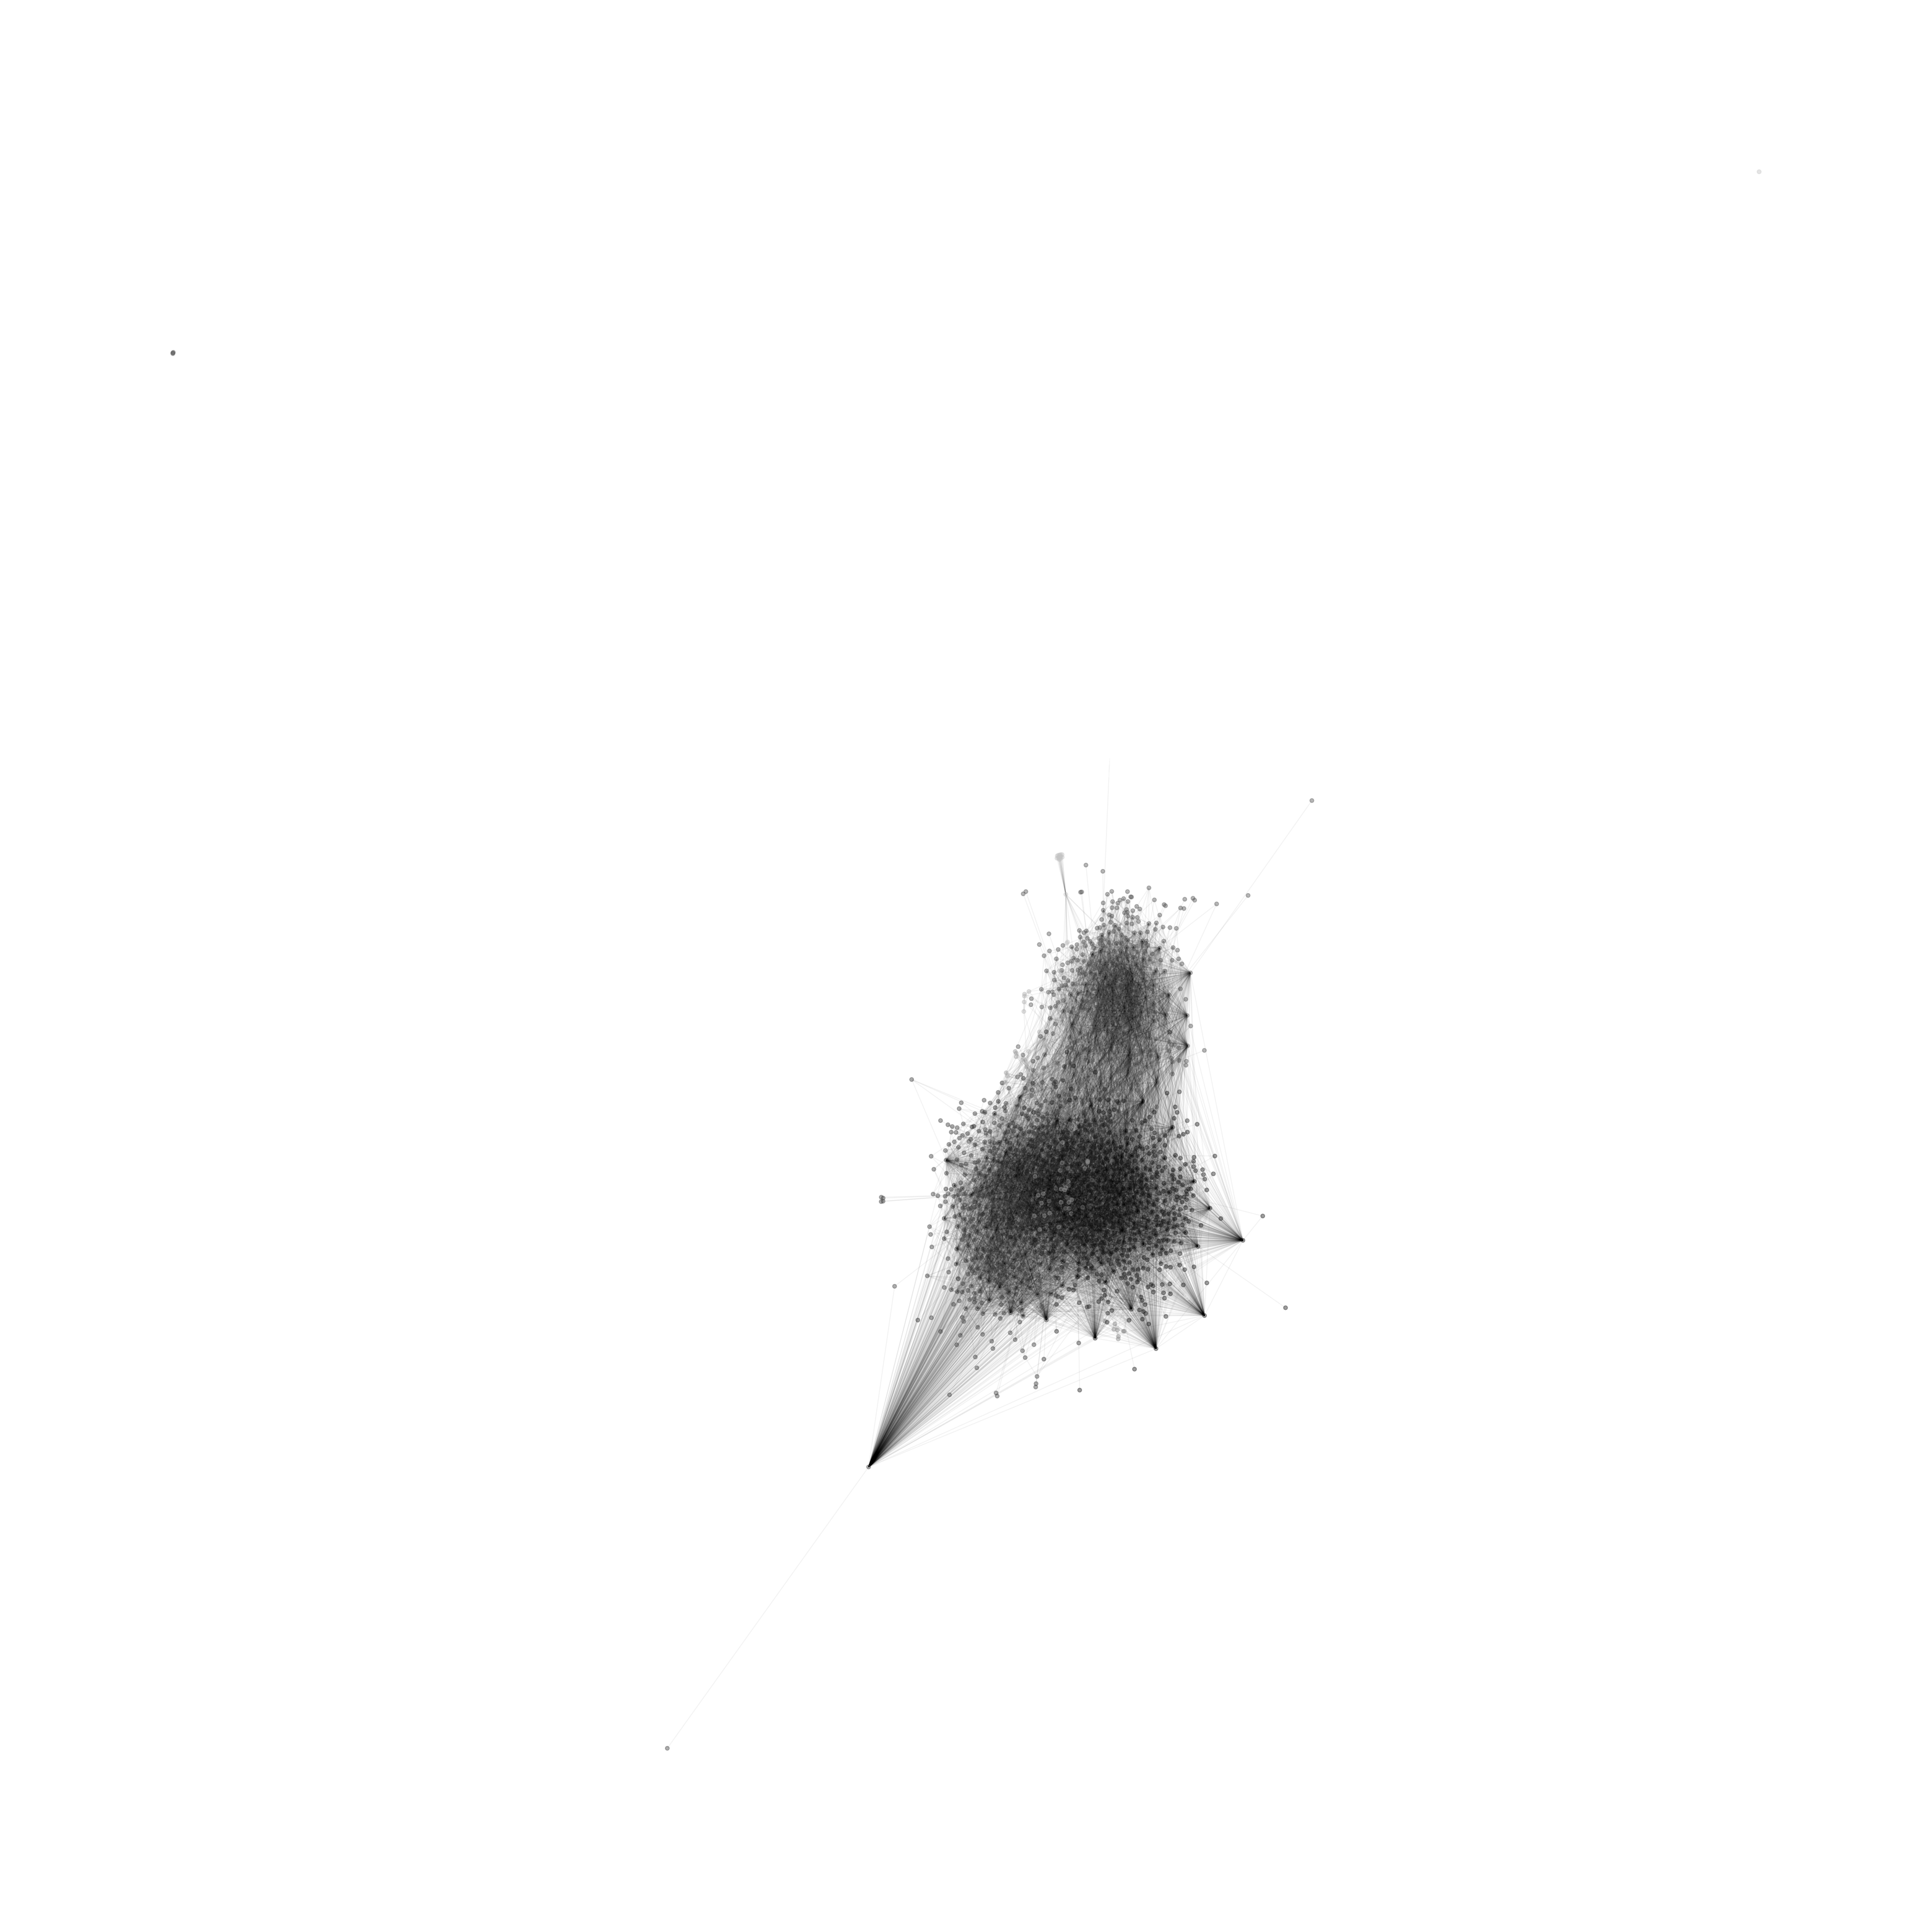

In [279]:
# See https://observablehq.com/@mef/forceatlas2-layout-settings-visualized
# for the effects of each parameter
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True, 
                        linLogMode=False,  
                        adjustSizes=False, 
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(marvel_graph, pos=None, iterations=2000)

# Colouring the nodes according to their community
f = 1.0
colorz = [(255/f, 0, 0), (0, 255/f, 0), (0, 0, 255/f), (255/f, 255/f, 0), (255/f, 0, 255/f), (0, 255/f, 255/f), (0, 0, 0),
         (130/f, 0, 0), (0, 130/f, 0), (0, 0, 130/f), (130/f, 130/f, 0), (130/f, 0, 130/f), (0, 130/f, 130/f),
          (130/f, 130/f, 130/f)]
node_color = [colorz[i] for i in list(partition.values())]

nx.draw_networkx_nodes(marvel_graph, positions, node_size=20, node_color=node_color, alpha=0.4)
nx.draw_networkx_edges(marvel_graph, positions, edge_color="black", alpha=0.05)

plt.axis('off')
plt.show()

>For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

In [43]:
# Remembering the 10 biggest communities
top_communities = {}

temp = list(partition.values())

for i in set(temp):
    top_communities[i] = temp.count(i)
    
top_communities = list(dict(reversed(sorted(top_communities.items(), key=lambda item: item[1]))))[:10]

# For a given community c, this function returns a string corresponding to all the text files of the heroes from this community
def stickTextFromCommunity(c):
    text = ""
    for e in marvel_graph.nodes:
        if partition[e] == c:
            with open(f'Heroes/{e}.txt') as f:
                for w in re.findall(r'\w+', f.read()):
                    text += w.lower()
                    text += " "
    return text

# Getting and storing all the texts from the top 10 communities
community_texts = {}
for c in top_communities:
    community_texts[c] = stickTextFromCommunity(c)
    
import nltk

# Counting the occurrences of every word in every community's text
community_fds = {}

for c in top_communities:
    community_fds[c] = nltk.FreqDist(community_texts[c].split())
    
# N is the total number of documents in the corpus
N = len(community_texts.values())

# This function computes the TF-IDF value for term t in document d (equivalent to the text of community c = d in our case)
def tfidf(t, d):
    # TF = raw count of term t in document d
    tf = community_fds[d][t]
    # IDF = N / |{d in D | t in d}|
    idf = np.log(N / np.sum([1 for c in top_communities if community_fds[c][t] > 0]))
    return tf*idf

# The elements of community_tfidfs are dictionaries which have all the unique terms in the community's text as keys,
# and the TF-IDF value of that term as values
community_tfidfs = {}

for c in top_communities:
    community_tfidfs[c] = {}
    for t in community_fds[c]:
        community_tfidfs[c][t] = tfidf(t, c)

$TF-IDF$ works by computing the frequency of a term in a given document, and taking into account its frequency in all the documents of the corpus, in order to estimate the relevance of the word for the document. It tries to answer the question <i>"Is this word important for this document in this corpus?"</i>.

>Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

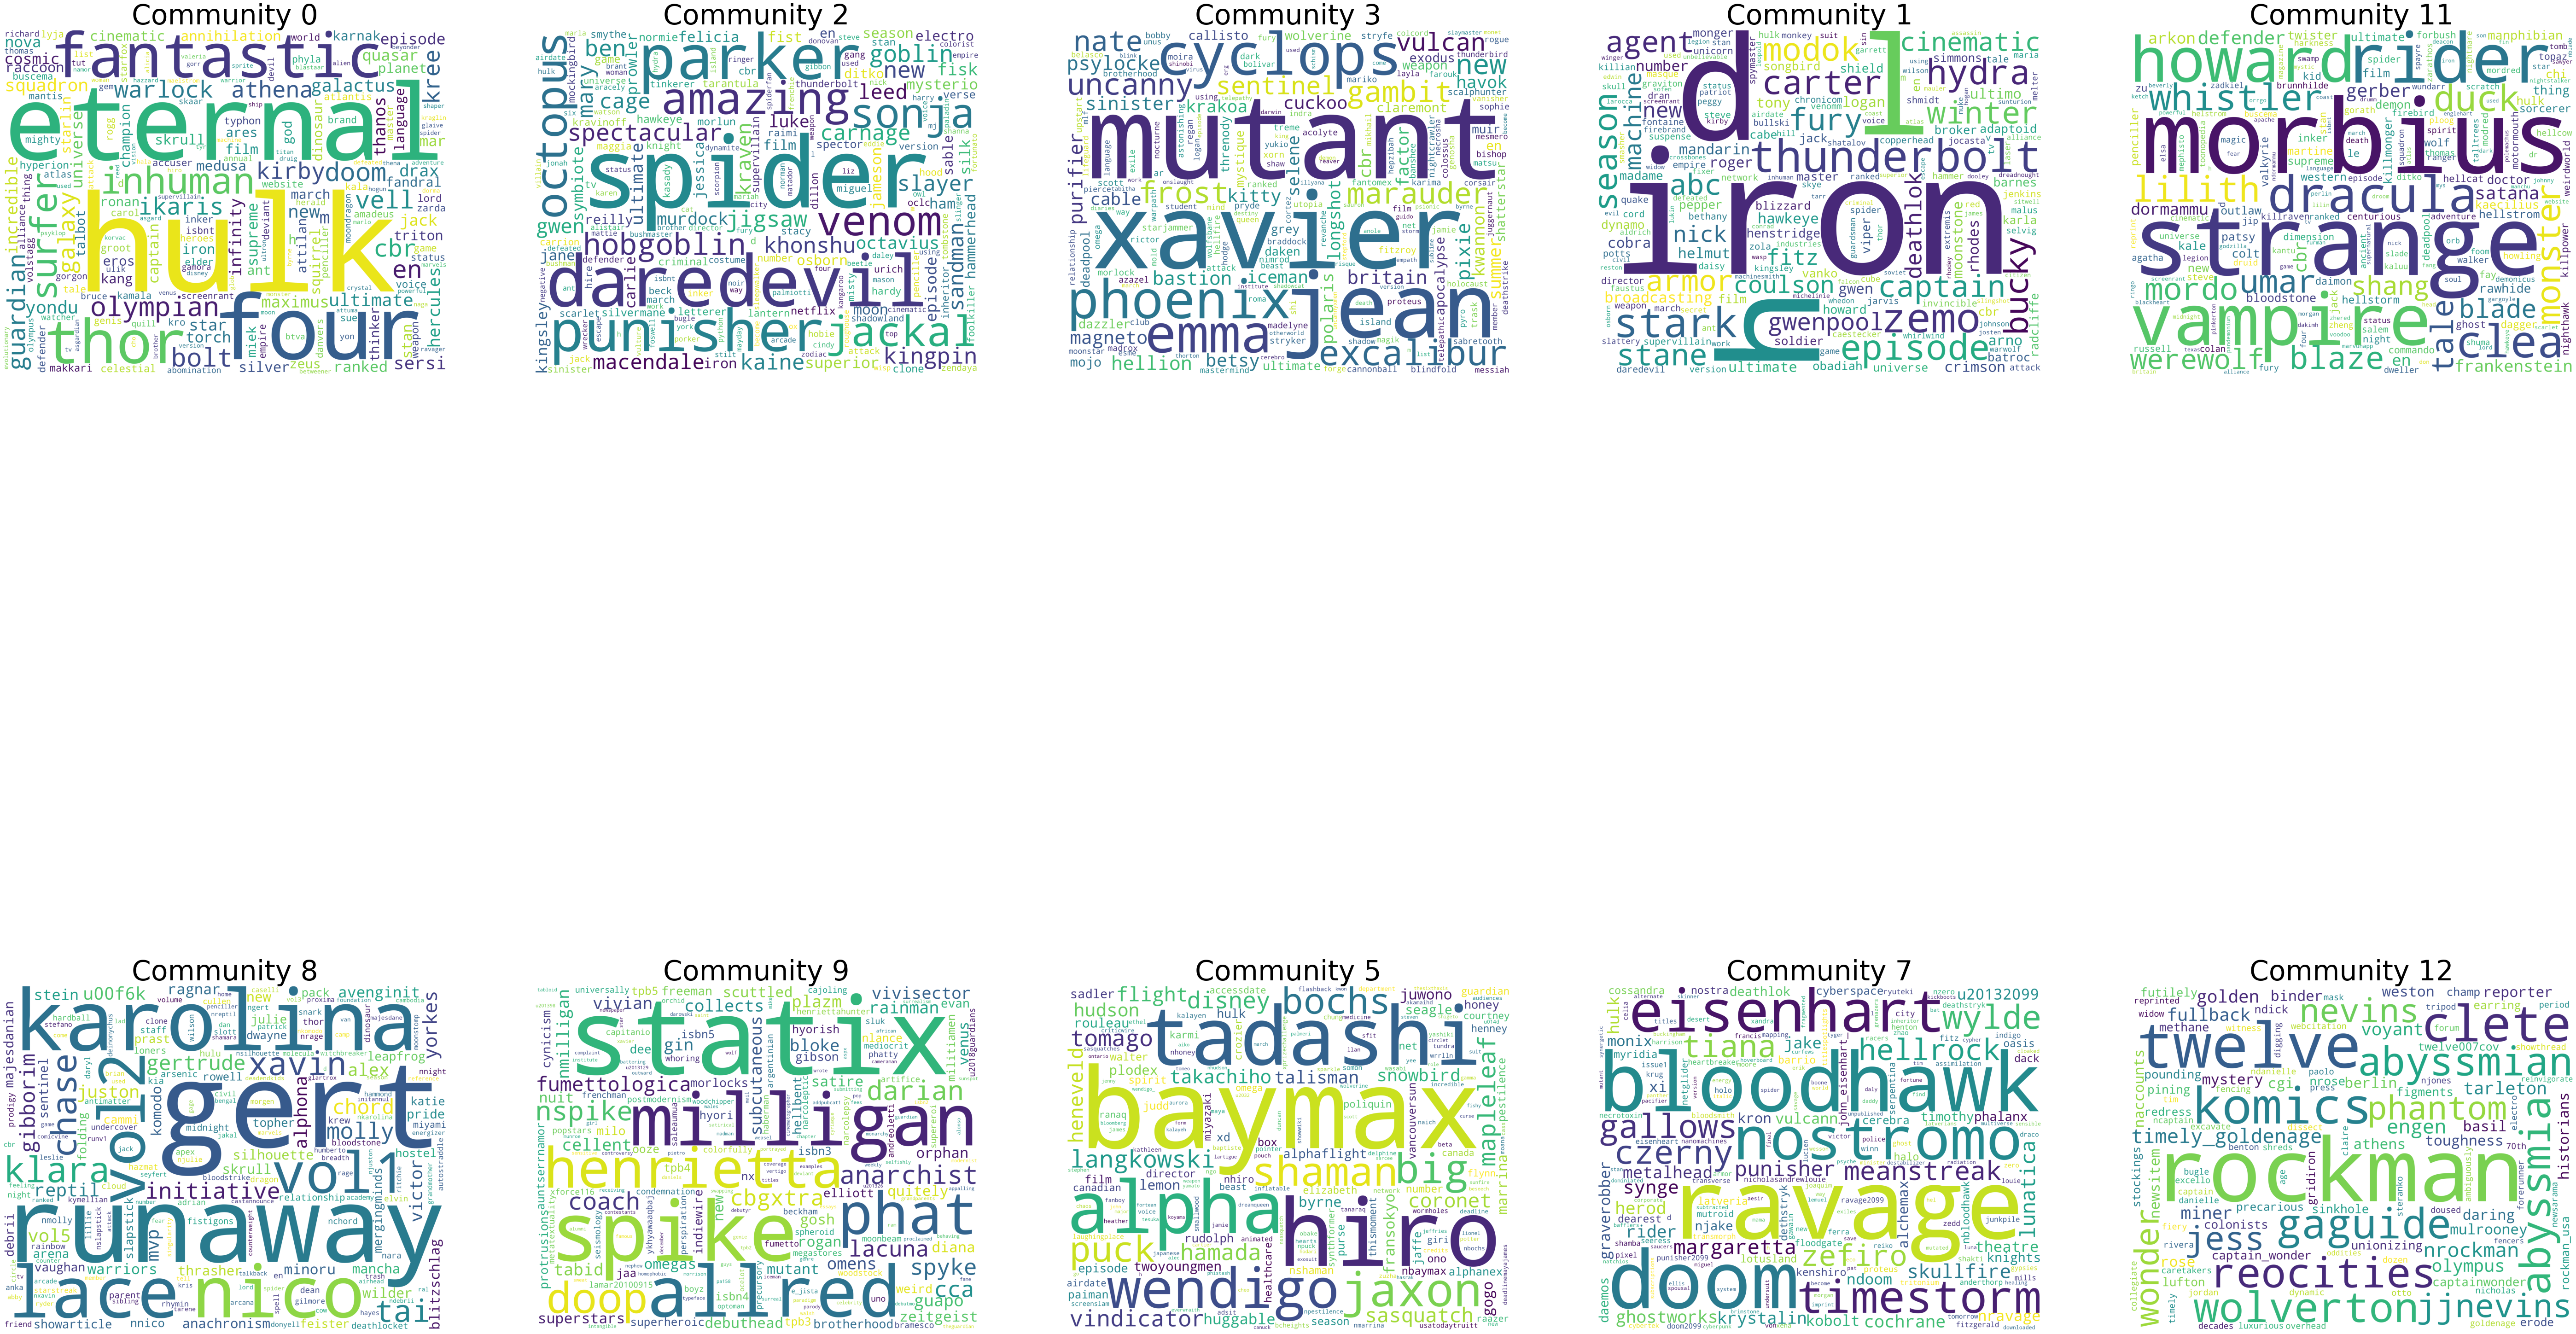

In [44]:
from wordcloud import WordCloud, STOPWORDS

# This function creates a string from a community's TF-IDF list
# by repeating each word according to its frequency (rounded as an integer)
def stringFromTfidf(c):
    string = ""
    for (w, f) in list(community_tfidfs[c].items()):
        string += (w + " ") * int(f)
    return string

# Then we can draw each community's wordcloud
figure, axis = plt.subplots(2, 5, figsize=(100,70))

i = 0
for c in top_communities:
    wc = WordCloud(collocations=False,
                          background_color='white',
                          stopwords=STOPWORDS,
                          width=3600,
                          height=2800
                         ).generate(stringFromTfidf(c))
    axis[int(i>=5), i + (-5)*(i>=5)].imshow(wc)
    axis[int(i>=5), i + (-5)*(i>=5)].set_title("Community "+str(c), fontsize = 60)
    axis[int(i>=5), i + (-5)*(i>=5)].axis('off')
    i += 1
    
plt.show()

Comment on the wordclouds obtained above:
- For some of the first communities (the first row), we can understand some features of the communities. Indeed, the first one (the order might change from one execution to the other) seems like it is linked to mythology and gods, the second one to the Spiderman "universe", and the third one to monsters and mutants.
- For the other communities, the wordclouds do not make a lot of sense to us.

## Sentiment

>First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

In [45]:
# Storing the sentiment values of words from the labMT wordlist
happiness = {}

with open('labMT.txt') as f:
    for w, h in re.findall(r'([a-z]+)\t\d+\t([\d.]+)', f.read()):
        happiness[w] = float(h)

'''
Maybe we should divide the total happiness by the number of words (that are actually inside the word list) ? DONE
That way we have a value reference (the labMT word list):
    - 8.50 is the highest
    - 1.30 is the lowest
'''

# This functions computes the total happiness of a text given its FreqDist "fd", and the word list "happiness"
def computeHappiness(fd):
    h = 0
    nb_words_recognized = 0
    for w in fd:
        # We use a try-except structure here because some words don't have a happiness value
        try:
            # We just weigh the value by the word's frequency
            h += (happiness[w] * fd[w])
            # We count how many words are recognized because we will use this to normalize the result
            nb_words_recognized += fd[w]
        except KeyError:
            pass
    return h, nb_words_recognized

# This is the part that computes the happiness for every character of the graph (for which at least one word was recognized)

character_happiness = []
for v in superhero_graph.nodes:
    text = ""
    with open(f'Heroes/{v}.txt') as f:
        for w in re.findall(r'\w+', f.read()):
            text += w.lower()
            text += " "
        text = text.split()
        fd = nltk.FreqDist(text)
        h, l = computeHappiness(fd)
        # If not a single word was recognized, it's useless
        if l > 0:
            character_happiness.append(h/l)

In [46]:
print("The mean happiness of all characters is:", np.mean(character_happiness))
print("The 10th percentile is:", np.percentile(character_happiness, 10))
print("The 90th percentile is:", np.percentile(character_happiness, 90))

The mean happiness of all characters is: 5.363470367563561
The 10th percentile is: 5.253962645291315
The 90th percentile is: 5.4776306907378345


In [47]:
#General Plotting function
def plot_histogram(data, title, xlim_lower=0, xlim_upper=10, ylim_lower=0, 
ylim_upper=1000, percentile_one=10, percentile_two=90, upperbound = 500):
    
    plt.figure(figsize=(15, 7))
    plt.xlim(xlim_lower, xlim_upper)
    plt.ylim(ylim_lower, ylim_upper)

    plt.hist(data)
    plt.xlabel("Happiness score", fontsize = 12)
    plt.ylabel("Number of nodes", fontsize = 12)
    plt.title(title, fontsize = 12)

    m = np.mean(data)
    plt.plot((m, m), (0, upperbound), color='r', label = 'Mean value')

    p = np.percentile(data, percentile_one)
    plt.plot((p, p), (0, upperbound), color='black', linestyle = 'dashed', label = f'{percentile_one}th percentile')

    p = np.percentile(data, percentile_two)
    plt.plot((p, p), (0, upperbound), color='black', linestyle = 'dashed', label = f'{percentile_two}th percentile')

    plt.legend()
    plt.show()

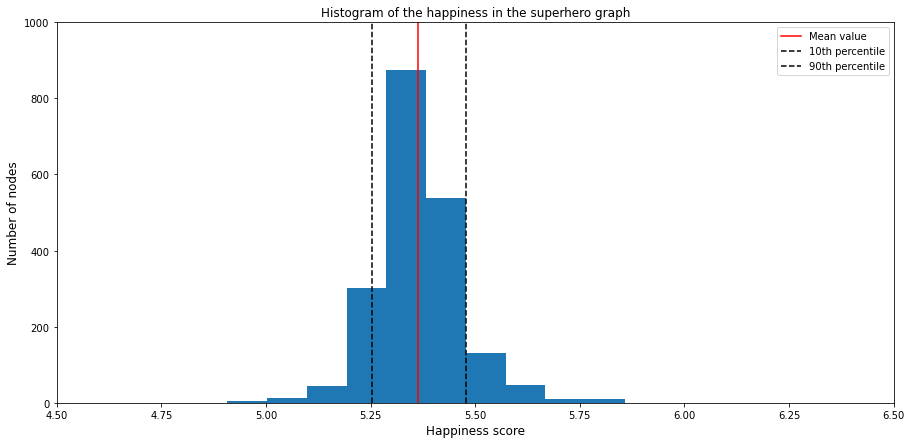

In [48]:
plot_histogram(character_happiness, "Histogram of the happiness in the superhero graph", xlim_lower=4.5, xlim_upper=6.5, upperbound=1000)

>Now grab the good/bad character names (from this file, see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.


In [49]:
character_affilaition = pd.read_csv('wiki_meta_data.csv')
good_character_happiness = []
bad_character_happiness = []

for v in superhero_graph.nodes:
    text = ""
    with open(f'Heroes/{v}.txt') as f:
        for w in re.findall(r'\w+', f.read()):
            text += w.lower()
            text += " "
        text = text.split()
        fd = nltk.FreqDist(text)
        h, l = computeHappiness(fd)
        # If not a single word was recognized, it's useless
        if l > 0:
            if character_affilaition.loc[character_affilaition['WikiLink'] == v, 'good'].item() == 1:
                good_character_happiness.append(h/l)
            elif character_affilaition.loc[character_affilaition['WikiLink'] == v, 'bad'].item() == 1:
                bad_character_happiness.append(h/l)


In [50]:
print("The mean happiness of good characters is:", np.mean(good_character_happiness))
print("The 10th percentile is:", np.percentile(good_character_happiness, 10))
print("The 90th percentile is:", np.percentile(good_character_happiness, 90))
print("The mean happiness of bad characters is:", np.mean(bad_character_happiness))
print("The 10th percentile is:", np.percentile(bad_character_happiness, 10))
print("The 90th percentile is:", np.percentile(bad_character_happiness, 90))

The mean happiness of good characters is: 5.38698447982966
The 10th percentile is: 5.294776809366392
The 90th percentile is: 5.490255901536027
The mean happiness of bad characters is: 5.337831354213807
The 10th percentile is: 5.251523378582206
The 90th percentile is: 5.4243749999999995


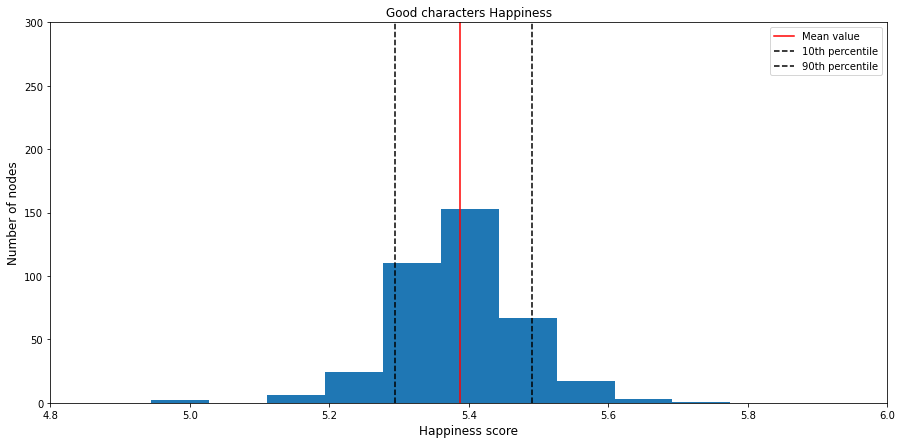

In [51]:
plot_histogram(good_character_happiness, title='Good characters Happiness', ylim_upper=300, xlim_lower=4.8, xlim_upper=6)

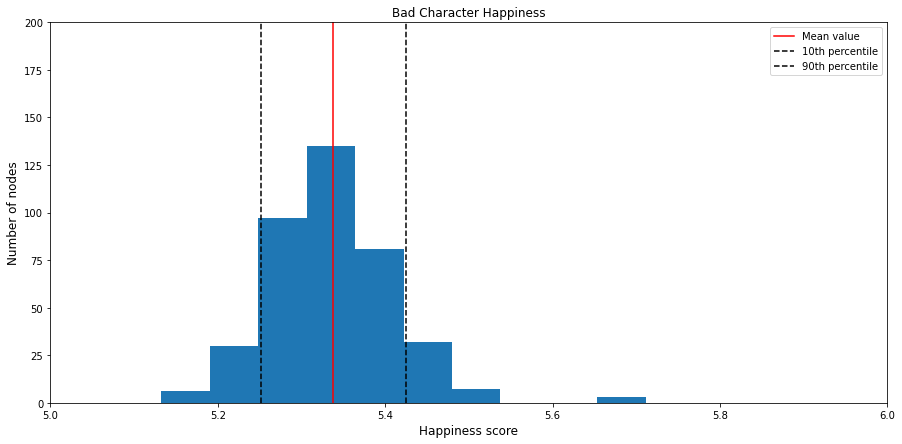

In [52]:
plot_histogram(bad_character_happiness, ylim_upper=200, title='Bad Character Happiness', xlim_lower=5, xlim_upper=6)

>Finally use the label permutation test (see Week 5) to investigate the two hypotheses below

>- H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
>- H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

In [56]:
#Function to permuatate data and returning a list with mean values
def permutate_data(number_of_nodes, data, permuted_distribution=[], iterations=1000):

    for i in range(iterations):
        random.shuffle(data)
        new_data = data[:number_of_nodes]
        permuted_distribution.append(np.mean(new_data))

    return permuted_distribution

In [57]:
#Creating data to be plotted
combined_data = good_character_happiness + bad_character_happiness #combining the two lists created before
good_charachters_permutations = permutate_data(len(good_character_happiness), combined_data)
bad_characters_permutations = permutate_data(len(bad_character_happiness), combined_data)

In [58]:
def plot_histogram_two(data, title, true_data):
    plt.figure(figsize=(15, 7))
    plt.hist(data)
    plt.xlabel("Happiness score", fontsize = 12)
    plt.ylabel("Number of nodes", fontsize = 12)
    plt.title(title, fontsize = 12)

    m = np.mean(data)
    plt.plot((m, m), (0, 500), color='r', label = 'Mean value')

    p = np.mean(true_data)
    plt.plot((p, p), (0, 500), color='black', linestyle = 'dashed', label = 'True Mean')

    plt.legend()
    plt.show()

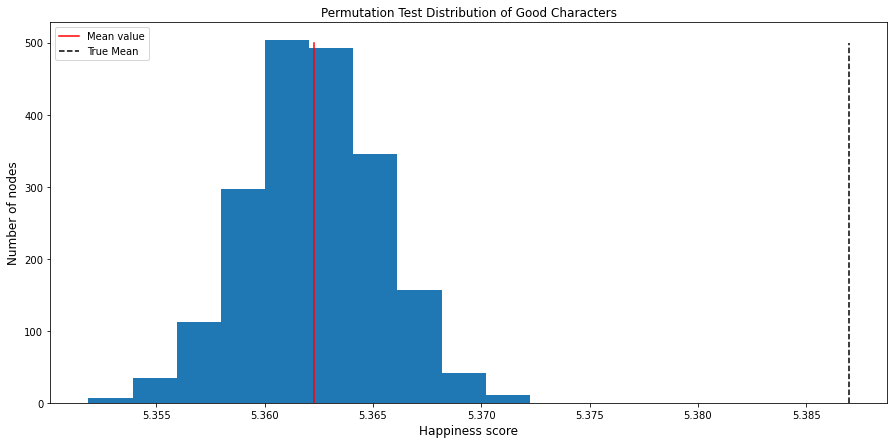

In [59]:
plot_histogram_two(good_charachters_permutations, title='Permutation Test Distribution of Good Characters', true_data=good_character_happiness)

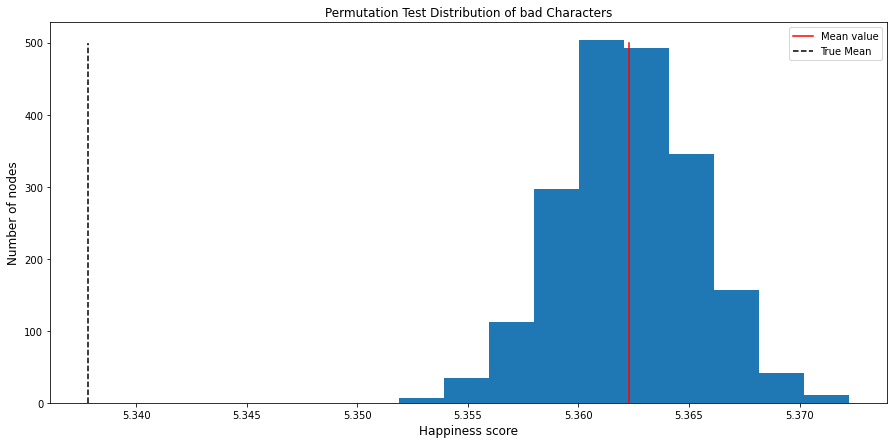

In [60]:
plot_histogram_two(bad_characters_permutations, title='Permutation Test Distribution of bad Characters', true_data=bad_character_happiness)

>Write a short paragraph reflecting on your findings.

We can see in the plots that both hypotheses seem to hold up since the average value for the Happiness score for good characters is higher than that we have plotted while it is the other way around for bad characters. This is expected since we assume that bad charachters are less happy than the good ones. 